# Machine Learning Project

## Data cleaning and feature engineering

In [75]:
import pandas as pd
import nltk
import numpy as np
from nltk.util import ngrams
from collections import Counter
from configparser import ConfigParser
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
#########################################################
##                                                     ##
##              IMPORTANT                              ##
## If it's the first time you run the program, please  ##
## uncomment the following lines :                     ##
##                                                     ##
#########################################################

#nltk.dowload('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')



In [76]:
#Load reviews and aggregate them in a str var
### Arguments : 
#   - path : The path of the file containing our data
### Output : 
#   - df : the dataframe corresponding to our data file
#   - reviews : An array containing all the reviews
def retrieveData(path):
    df = pd.read_json(path, lines=True)

    reviews = []
    for review in df['reviewText'].items():
        reviews.append(review[1])

    return (df, reviews)

In [172]:
#Tokenize and return ('word',#apparitions) for the most common nb_token
def tokenize(reviews, nb_tokens=100):
    #We start with a string containg all the reviews
    #We retrieve all the words, then only keep alphabetic ones (no numbers)
    tokens = nltk.tokenize.word_tokenize(reviews)
    alpha_tokens = [t for t in tokens if t.isalpha()] 
    #We get rid of capital letters, in order to count word occurence properly
    lower_tokens = [t.lower() for t in alpha_tokens]
    

    #Lemmatizer
    wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized_tokens = [wordnet_lemmatizer.lemmatize(t) for t in lower_tokens]
    
    #Get words tag
    tagged = nltk.pos_tag(lemmatized_tokens)
    
    #We get rid of stop words 
    stop_words = nltk.corpus.stopwords.words('english')
    new_sw = ['phone','wa','month','year','day','iphone', 'time','ha','way','wife']
    stop_words.extend(new_sw)
    no_stops_tokens = [t for t in tagged if t[0] not in(stop_words)]
    
    count = Counter(no_stops_tokens)
    return count.most_common(nb_tokens)

In [173]:
#Tag filter
def tag(tokens_tag, tag):
    return [t[0][0] for t in tokens_tag if t[0][1] == tag]

In [174]:
#Extract most relevant features from all the reviews
def extract(reviews):
    totalReviews = " "
    for review in reviews:
        totalReviews = totalReviews + review + "\n"
        
    # Retrieve the 300 most common relevant words 
    token_tag_count = tokenize(totalReviews, 500)
    tokens_tag = [[t[0],t[1]] for t in token_tag_count]
        
    # Retrieve the nouns out of the 300 most common words
    nouns = tag(tokens_tag, 'NN')
    print('nouns : ', nouns[0:30])
    #adjectives=tag(tokens,'JJ')
    #return nouns[0:30], adjectives[0:20]
    return nouns[0:30]

In [175]:
#Filtering most common words if reviews
def filter(review, features):
    tokens = [t[0][0] for t in tokenize(review)]
    filtered_tokens = [t for t in tokens if t in features]
    return filtered_tokens

In [176]:
def prepareData(df, reviews):
    # We call the extract method to retrieve the most relevant words (features)
    features = extract(reviews)  
    
    # For each review, we only keep the words that are features
    filtered_tokens = [filter(review, features) for review in reviews]
    filtered_reviews = []
    for f in filtered_tokens:
        review = ""
        for t in f:
            review = review + t + " "
        filtered_reviews.append(review)

    # We create a column for each feature
    # If that feature is mentioned in the review : the value is 1, else 0
    cv = CountVectorizer(binary=True)
    x = cv.fit_transform(filtered_reviews)
    return pd.DataFrame(x.toarray(), columns=cv.get_feature_names())

In [177]:
config = ConfigParser()
config.read('init.cfg')
path = config['RESOURCES']['path']
dataFile = config['RESOURCES']['dataFile']

# We retrieve a dataframe corresponding to our data file
# and an array containing only the reviews
df, reviews = retrieveData(path + dataFile)

# We add to it columns. One for each feature (relevant word).
# If a review contains a feature, the corresponding column will have value 1, else 0.
df_features = prepareData(df, reviews)

nouns :  ['case', 'otterbox', 'screen', 'protection', 'product', 'defender', 'color', 'rubber', 'protector', 'plastic', 'price', 'cover', 'box', 'thing', 'holster', 'silicone', 'pocket', 'work', 'part', 'clip', 'quality', 'belt', 'problem', 'button', 'drop', 'otter', 'bit', 'lot', 'series', 'flap']


## Data Visualization

In [178]:
dfwc=df.filter(['reviewText','overall'], axis =1)
dfwc['GoodRating'] = np.where(dfwc.overall>2.5,1,0)
df_pos = dfwc[dfwc['GoodRating'] == 1]
df_neg = dfwc[dfwc['GoodRating']==0]

In [179]:
reviewpos = []
for review in df_pos['reviewText'].items():
    reviewpos.append(review[1])
strpos=''.join(reviewpos)

In [180]:
reviewneg = []
for review in df_neg['reviewText'].items():
    reviewneg.append(review[1])
strneg = ''.join(reviewneg)

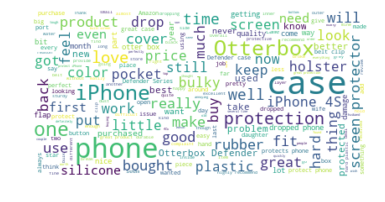

In [181]:
# Generate a word cloud image
wordcloud = WordCloud(max_font_size=40, background_color = 'white').generate(strpos)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

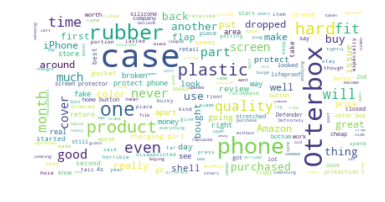

In [182]:
# Generate a word cloud image
wordcloud = WordCloud(max_font_size=40, background_color = 'white').generate(strneg)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Model Tuning

In [183]:
dataset = df_features
dataset['GoodRating'] = np.where(df.overall>2.5,1,0)

In [184]:
X = dataset.drop(['GoodRating'], axis = 1)
y = dataset['GoodRating']

## Logistic Regression

In [185]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from treeinterpreter import treeinterpreter as ti
import json
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings("ignore")

In [186]:
#evaluate performances
from sklearn.metrics import make_scorer, accuracy_score 
from sklearn.model_selection import GridSearchCV

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=0.20, random_state=0, stratify = y)

In [188]:
np.shape(X_train)

(669, 30)

In [189]:
cv_sets = model_selection.StratifiedShuffleSplit(n_splits = 2, test_size = 0.20, random_state = 5)
cv_sets.get_n_splits(X_train, y_train)

2

In [190]:
#Logistic Regression 
logreg_clf = LogisticRegression()

parameters_logreg = { "fit_intercept": [True, False], "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
                     "max_iter": [50, 100, 200]}

grid_logreg = GridSearchCV(logreg_clf, parameters_logreg, scoring=make_scorer(accuracy_score), cv = cv_sets)
grid_logreg.fit(X_train, y_train)

logreg_clf = grid_logreg.best_estimator_

logreg_clf.fit(X_train, y_train)
pred_logreg = logreg_clf.predict(X_test)
acc_logreg = accuracy_score(y_test, pred_logreg)

print("The Score for Logistic Regression is: " + str(acc_logreg))
grid_logreg.best_params_

The Score for Logistic Regression is: 0.9285714285714286


{'fit_intercept': True, 'max_iter': 50, 'solver': 'liblinear'}

In [195]:
feature_to_coef = {
    word: coef for word, coef in zip(
        df_features.columns, logreg_clf.coef_[0]
    )
}

print('The most liked features are :')
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
    
print('\n'+'The most disliked features are : ')    
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

The most liked features are :
('protection', 1.007804546487515)
('drop', 0.9107579759870946)
('protector', 0.6721879917088206)
('case', 0.6111425404237839)
('color', 0.4929593305807574)

The most disliked features are : 
('rubber', -1.0809318700584822)
('flap', -0.8945230852742136)
('plastic', -0.8129103684020041)
('button', -0.7583615701034944)
('quality', -0.4584632778685534)


## SVM

In [141]:
svc_clf = SVC() 

parameters_svc = {"kernel": ["linear"], "probability": [True, False]}

grid_svc = GridSearchCV(svc_clf, parameters_svc, scoring=make_scorer(accuracy_score), cv = cv_sets)
grid_svc.fit(X_train, y_train)

svc_clf = grid_svc.best_estimator_

svc_clf.fit(X_train, y_train)
pred_svc = svc_clf.predict(X_test)
acc_svc = accuracy_score(y_test, pred_svc)
print("The Score for SVC is: " + str(acc_svc))
grid_svc.best_params_

The Score for SVC is: 0.9285714285714286


{'kernel': 'linear', 'probability': True}

In [142]:
np.shape(svc_clf.support_)

(155,)

In [143]:
np.shape(svc_clf.support_vectors_)

(155, 30)

In [144]:
svc_clf.support_

array([  0,  10,  54,  77,  86,  88,  93, 126, 127, 133, 135, 138, 151,
       165, 182, 192, 198, 214, 226, 260, 268, 271, 279, 292, 299, 318,
       320, 328, 340, 352, 353, 359, 368, 380, 439, 444, 449, 460, 479,
       494, 498, 518, 529, 543, 564, 572, 592, 598, 622, 662,   5,  14,
        49,  59,  61,  76,  90,  92,  95, 105, 111, 112, 113, 118, 147,
       167, 173, 176, 183, 188, 193, 196, 210, 213, 227, 237, 241, 243,
       248, 253, 254, 258, 278, 283, 285, 295, 303, 304, 313, 314, 324,
       325, 327, 343, 358, 364, 369, 376, 378, 381, 387, 388, 399, 402,
       414, 424, 426, 428, 440, 447, 453, 454, 456, 457, 463, 473, 484,
       487, 499, 500, 503, 513, 522, 523, 524, 525, 530, 538, 551, 552,
       561, 574, 576, 577, 587, 600, 608, 612, 615, 621, 629, 632, 636,
       637, 639, 640, 641, 643, 649, 654, 657, 660, 661, 665, 666])

In [145]:
np.shape(svc_clf.coef_)

(1, 30)

In [146]:
feature_to_coef = {
    word: coef for word, coef in zip(
        df_features.columns, svc_clf.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
    
    
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

('series', 0.0006917214031693097)
('wife', 0.0002697761317064229)
('bit', 0.000251944530734966)
('product', 0.00015204665295565079)
('screen', 0.0001332533948640302)
('belt', -0.00021575883702817933)
('defender', -0.00021453732134885106)
('holster', -0.00019089705456212802)
('button', -0.00018734279220317118)
('quality', -0.00015192759967456136)


## Naive Bayes

In [147]:
#GaussianNB
GNB_clf = GaussianNB()
GNB_clf.fit(X_train,y_train)

pred_gnb = GNB_clf.predict(X_test)
acc_gnb = accuracy_score(y_test, pred_gnb)


print("The Score for GaussianNB is: " + str(acc_gnb))

The Score for GaussianNB is: 0.8571428571428571


In [148]:
np.shape(GNB_clf.theta_)

(2, 30)

In [149]:
GNB_clf.theta_

array([[0.04      , 0.04      , 0.1       , 0.18      , 0.5       ,
        0.04      , 0.08      , 0.14      , 0.1       , 0.04      ,
        0.06      , 0.04      , 0.08      , 0.32      , 0.16      ,
        0.24      , 0.08      , 0.1       , 0.06      , 0.2       ,
        0.06      , 0.08      , 0.12      , 0.34      , 0.2       ,
        0.02      , 0.06      , 0.14      , 0.02      , 0.08      ],
       [0.05169628, 0.06785137, 0.08885299, 0.0549273 , 0.62035541,
        0.06300485, 0.14701131, 0.11147011, 0.12924071, 0.13408724,
        0.06300485, 0.06462036, 0.06946688, 0.33441034, 0.06623586,
        0.10016155, 0.06138934, 0.10662359, 0.06462036, 0.16801292,
        0.20355412, 0.11308562, 0.05654281, 0.12116317, 0.20193861,
        0.04684976, 0.05654281, 0.0904685 , 0.06462036, 0.11631664]])

In [150]:
accuracy_score(y_train,GNB_clf.predict(X_train))

0.8221225710014948

## Decision Tree

In [165]:
#DecisionTreeClassifier 
DT_clf = DecisionTreeClassifier()

parameters_dt = {"max_depth": [5,6,7,10],"min_samples_split": [2, 3, 5, 10], "max_features": ["auto", "sqrt", "log2"],
                 "criterion": ["gini"] }

grid_dt = GridSearchCV(DT_clf, parameters_dt, scoring=make_scorer(accuracy_score), cv = cv_sets)
grid_dt.fit(X_train, y_train)

DT_clf = grid_dt.best_estimator_

DT_clf.fit(X_train, y_train)
pred_dt = DT_clf.predict(X_test)
acc_dt = accuracy_score(y_test, pred_dt)

print("The Score for DecisionTree is: " + str(acc_dt))
grid_dt.best_params_

The Score for DecisionTree is: 0.9285714285714286


{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_split': 10}

In [166]:
feature_importances = DT_clf.feature_importances_

##### Interpreting contribution of each feature for a given class

In [168]:
prediction, bias, contributions = ti.predict(DT_clf, X)

In [169]:
np.shape(contributions)

(837, 30, 2)

In [170]:
totalc = np.mean(contributions, axis=0)
totalc0 = totalc[:,0]
totalc1 = totalc[:,1]

In [171]:
feature_to_coef3 = {
    word: coef for word, coef in zip(
        df_features.columns, totalc0
    )
}
for best_positive in sorted(
    feature_to_coef3.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)
feature_to_coef4 = {
    word: coef for word, coef in zip(
        df_features.columns, totalc1
    )
}
for best_negative in sorted(
    feature_to_coef4.items(), 
    key=lambda x: x[1], reverse = True)[:5]:
    print (best_negative)
    

('belt', 0.0005616929346491902)
('pocket', 0.0003123071386886083)
('protector', 0.00022888100783150815)
('part', 0.00018667861409796895)
('problem', 0.00016942641457465689)
('rubber', 0.0018449729307568148)
('protection', 0.0004636895486537374)
('button', 0.0002818099686615047)
('plastic', 0.00015860611229126252)
('screen', 0.00010148374025264803)
